# Applying different Algorithm

In [3]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score

In [10]:
df = pd.read_csv("creditcard.csv")
df.shape

(284807, 31)

In [11]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Our dataset is heavily imbalanced

# Train-Test-Split

60% Training
20% Validation
20% Test

In [12]:
data = df.drop(columns=['Class'], axis=1)
answer = df['Class']

In [13]:
X_break, X_test, y_break, y_test = train_test_split(data, answer, \
                                                    test_size=0.2, stratify=df['Class'],
                                                    random_state=42)

#random_state generates a set kind of deck for each random state. 42 will always be the same kind of split
X_train, X_val, y_train, y_val = train_test_split(X_break, y_break, \
                                                    test_size=0.25, stratify=y_break,
                                                    random_state=42)
# Initialize fit StandardScaler
std_scale = StandardScaler().fit(X_train)

# Scale data
X_train_std = std_scale.transform(X_train)
X_val_std = std_scale.transform(X_val)
X_test_std = std_scale.transform(X_test)

# To deal with the imbalanced classes, we will use undersampling

In [14]:
X_train_under, y_train_under = RandomUnderSampler(random_state=42).fit_sample(X_train_std,y_train)
X_val_under, y_val_under = RandomUnderSampler(random_state=42).fit_sample(X_val_std,y_val)

# Apply KNN on the dataset, find out the best k using 5-Folds CV.

In [15]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x%2!=0, myList))  #This will give a list of odd numbers only ranging from 0 to 50

CV_Scores = []

for k in neighbors:
    KNN = KNeighborsClassifier(n_neighbors = k, algorithm = 'kd_tree')
    scores = cross_val_score(KNN, X_train_under, y_train_under, cv = 5, scoring='recall')
    CV_Scores.append(scores.mean())

In [16]:
CV_Scores

[0.9084745762711863,
 0.9016949152542372,
 0.8983050847457626,
 0.894915254237288,
 0.888135593220339,
 0.8813559322033898,
 0.8915254237288137,
 0.8847457627118646,
 0.8847457627118646,
 0.8847457627118646,
 0.8813559322033899,
 0.8813559322033899,
 0.8745762711864407,
 0.8677966101694915,
 0.8677966101694915,
 0.8610169491525423,
 0.8576271186440678,
 0.8542372881355933,
 0.8542372881355933,
 0.8508474576271187,
 0.8508474576271187,
 0.8474576271186441,
 0.8440677966101695,
 0.8372881355932205,
 0.8338983050847458]

In [17]:
best_k = neighbors[CV_Scores.index(max(CV_Scores))]
best_k

1

In [18]:
params_knn = {'n_neighbors': range(1, 32, 1)}
knn = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'kd_tree')
grid_knn = GridSearchCV(knn, params_knn, scoring = 'roc_auc', cv=5)
grid_knn.fit(X_train_under, y_train_under)

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(algorithm='kd_tree', n_neighbors=1),
             param_grid={'n_neighbors': range(1, 32)}, scoring='roc_auc')

# Logistic Regression

In [19]:

# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.15443469e+01, 4.64158883e+02, 1.00000000e+04,
       2.15443469e+05, 4.64158883e+06, 1.00000000e+08, 2.15443469e+09,
       4.64158883e+10, 1.00000000e+12]),
                         'penalty': ['l2']},
             scoring='roc_auc', verbose=10)

# Naive Bayes

In [20]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train_under, y_train_under)

# Random Forest

In [21]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 700]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train_under,y_train_under)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 700]},
             scoring='roc_auc', verbose=10)

# Dummy Classifier

In [22]:
dummy = DummyClassifier()
dummy.fit(X_train_under, y_train_under)

F:\s\ana\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


DummyClassifier()

# Find ROC scores for all models

In [30]:
def roc_scores(X_value, Y_value):
    #in sample
    model_list = [logistic_grid.best_estimator_, 
                   grid_knn.best_estimator_, 
                  gnb_best,
                  rf_grid.best_estimator_,
                  dummy
                 ]

    model_name = ['Logit','KNN','Naive Bayes','Random Forest','Dummy']

    # Plot ROC curve for all my models
    fig, ax = plt.subplots(figsize=(20,18))
    for i, model in enumerate(model_list):
        y_pred = list(model.predict_proba(X_value)[:,1])
        fpr, tpr, threshold = metrics.roc_curve(Y_value, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc),linewidth=2.0)
    ax.grid(False)
    ax.tick_params(length=6, width=2,labelsize = 30,
                   grid_color='r', grid_alpha=0.5)
    # plt.legend(loc = 'lower right',prop={'size': 25})
    leg = plt.legend(loc = 'lower right',prop={'size': 25})
    leg.get_frame().set_edgecolor('b')
    plt.title('Receiver Operating Characteristic (ROC)', FontSize=40)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('True Positive Rate',FontSize=30)
    plt.xlabel('False Positive Rate',FontSize=30)
    plt.show()

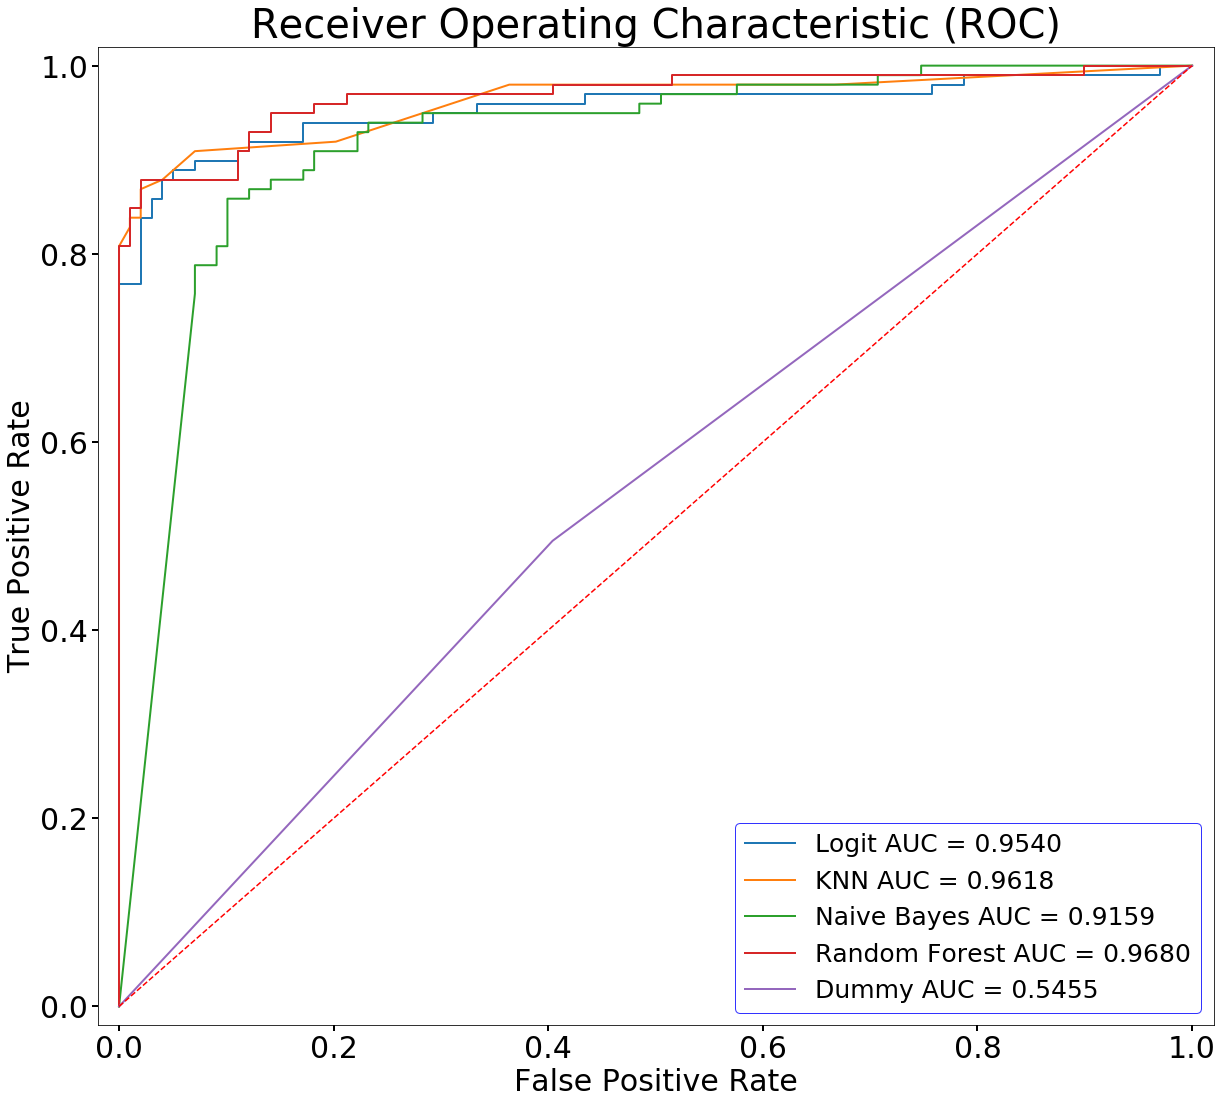

In [31]:
#in sample
roc_scores(X_val_under,y_val_under)

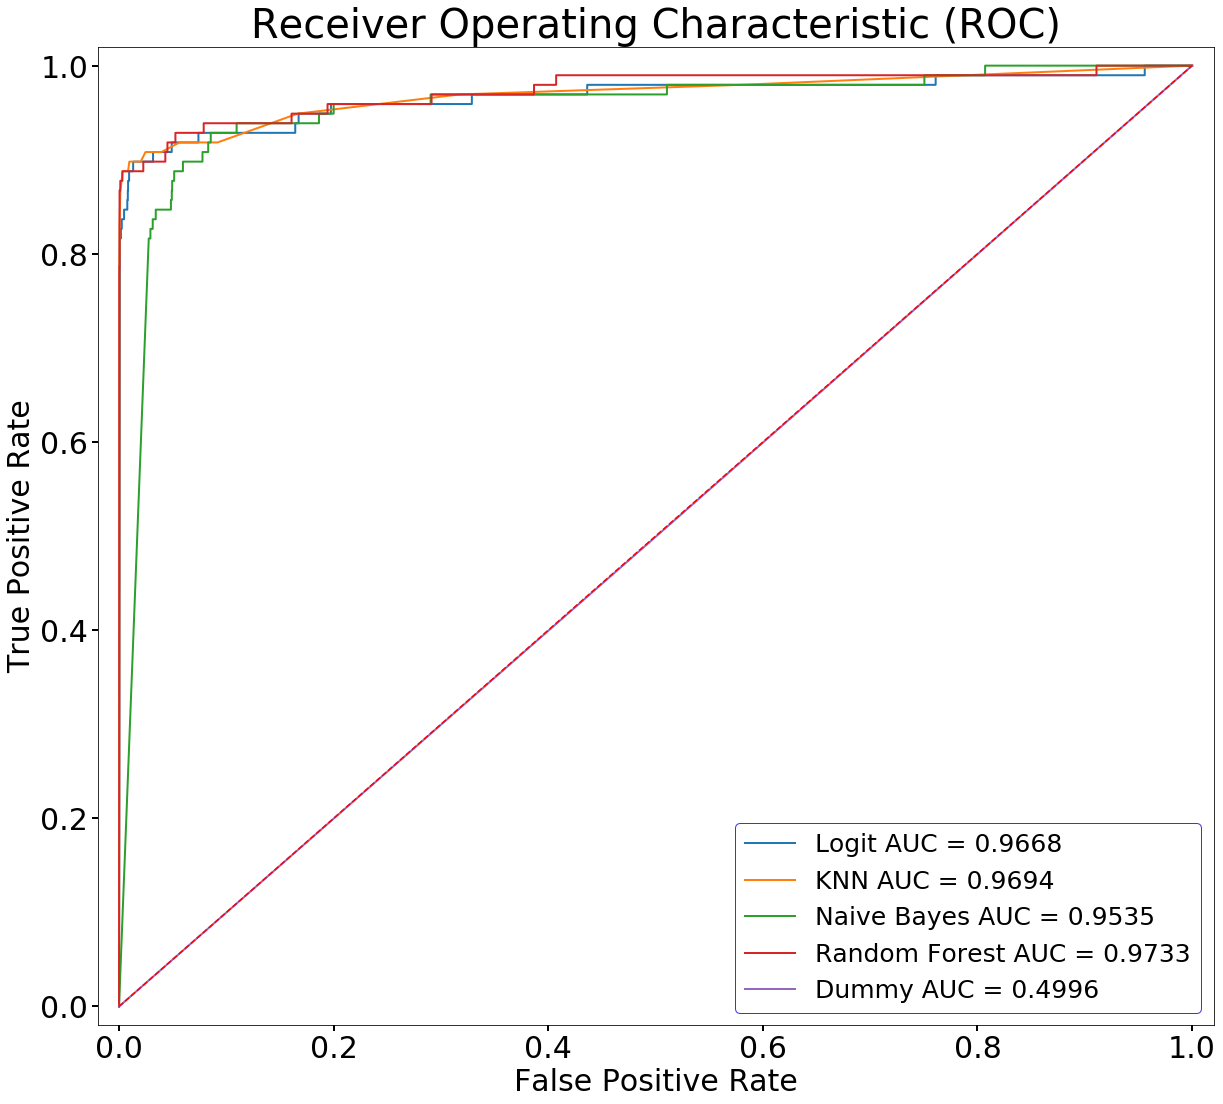

In [32]:
#out of sample
roc_scores(X_test_std,y_test)

# Find the best threshold for each model

In [33]:
def find_best_threshold(model, int_num_steps):
    highest_f1 = 0
    best_threshold = 0
    for threshold in np.linspace (0, 1, int_num_steps):
        y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold) 
        f1 = f1_score(y_val_under,y_predict)
        acc = accuracy_score(y_val_under,y_predict)
        rec = recall_score(y_val_under,y_predict)
        pre = precision_score(y_val_under,y_predict)
        if f1 > highest_f1:
            best_threshold, highest_f1, best_acc, best_rec, best_pre  = \
                threshold, f1, acc, rec, pre
    return best_threshold, highest_f1, best_acc, best_rec, best_pre

In [34]:
models = [logistic_grid, grid_knn, gnb_best, rf_grid]
model_names = ["Logistic Regression", "KNN", "Naive-Bayes", "Random Forest"]
chart = list()
for item,name in zip(models,model_names):
    best_thresh, high_f1, high_acc, high_rec, high_pre = find_best_threshold(item,20)
#     print(f'Results for {name}:')
#     print('Best Threshold: ', best_thresh)
#     print('Highest_f1: ', high_f1)
    chart.append([name, best_thresh, high_f1, high_acc, high_rec, high_pre])

In [35]:
chart = pd.DataFrame(chart, columns=['Model', 'Best Threshhold','F1 Score','Accuracy','Recall','Precision'])
chart

,Model,Best Threshhold,F1 Score,Accuracy,Recall,Precision
0,Logistic Regression,0.842105,0.916667,0.919192,0.888889,0.946237
1,KNN,0.210526,0.919786,0.924242,0.868687,0.977273
2,Naive-Bayes,0.052632,0.870466,0.873737,0.848485,0.893617
3,Random Forest,0.421053,0.919786,0.924242,0.868687,0.977273


# Confusion Matrix

In [36]:

def make_confusion_matrix_val(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_val_under, y_predict)
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud']);
    TP = fraud_confusion[0][0]
    FP = fraud_confusion[0][1]
    FN = fraud_confusion[1][0]
    TN = fraud_confusion[1][1]
    plt.yticks(rotation = 0)
    plt.title('Predicted vs. Actual',fontname = '.SF Compact Display',fontsize = 20,pad = 10);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

findfont: Font family ['.SF Compact Display'] not found. Falling back to DejaVu Sans.


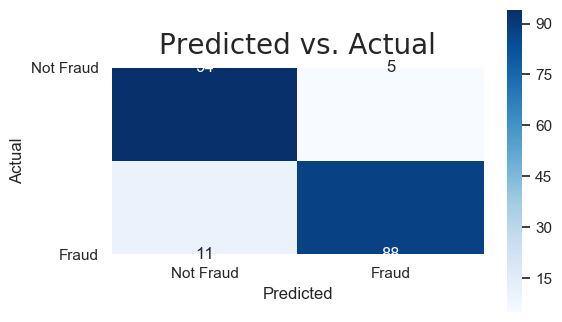

In [37]:
#fixed confusion matrix - logistic regression, validation
make_confusion_matrix_val(logistic_grid, threshold=0.842105)

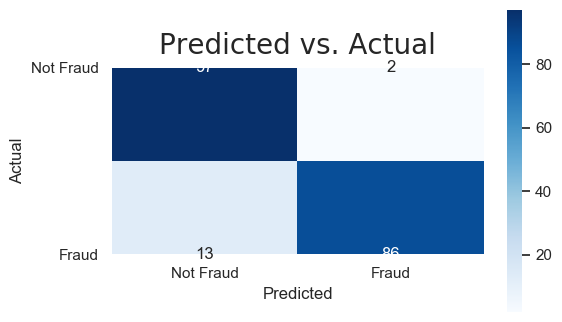

In [39]:
#fixed confusion matrix - knn, validation
make_confusion_matrix_val(grid_knn, threshold=0.210526)

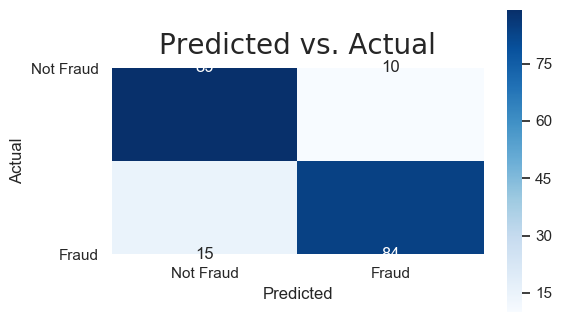

In [40]:
#fixed confusion matrix - naive bayes, validation
make_confusion_matrix_val(gnb_best, threshold=0.052632)

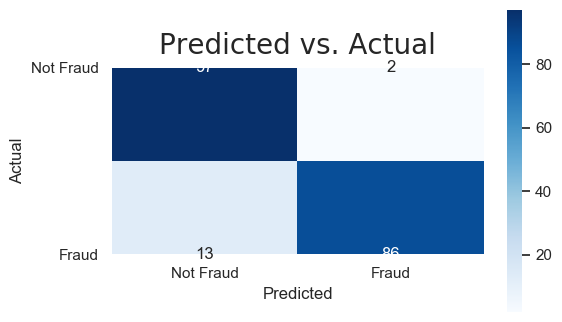

In [42]:
#fixed confusion matrix - random forest, validation
make_confusion_matrix_val(rf_grid, threshold=0.421)

In [43]:
def make_confusion_matrix_test(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_std)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud']);
    TP = fraud_confusion[0][0]
    FP = fraud_confusion[0][1]
    FN = fraud_confusion[1][0]
    TN = fraud_confusion[1][1]
    plt.yticks(rotation = 0)
    plt.title('Predicted vs. Actual',fontname = '.SF Compact Display',fontsize = 20,pad = 10);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

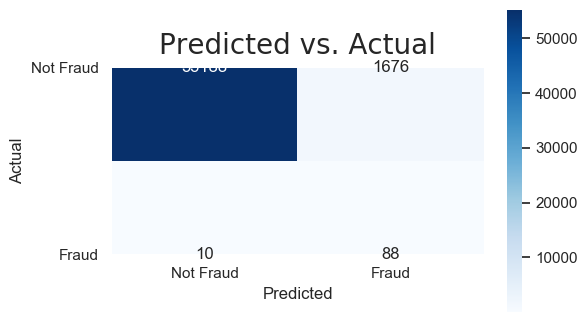

In [47]:
#fixed confusion matrix - logistic regression, validation
make_confusion_matrix_test(logistic_grid, threshold=0.842105)

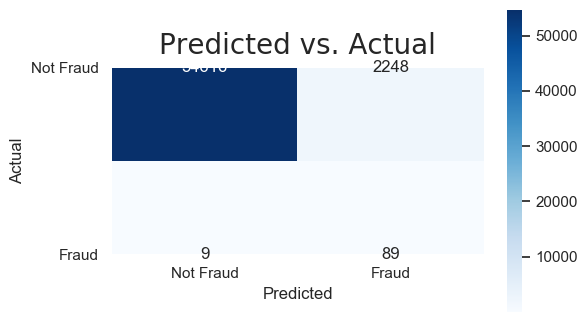

In [48]:
#fixed confusion matrix - knn, validation
make_confusion_matrix_test(grid_knn, threshold=0.210526)

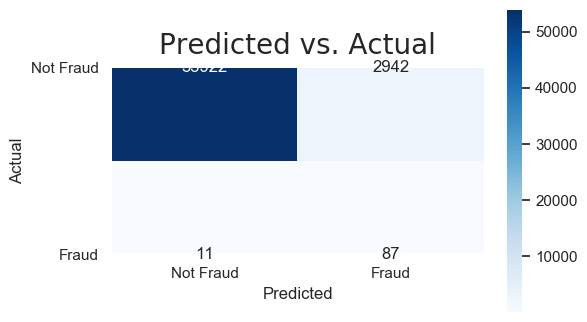

In [49]:
#fixed confusion matrix - naive bayes, validation
make_confusion_matrix_test(gnb_best, threshold=0.052632)

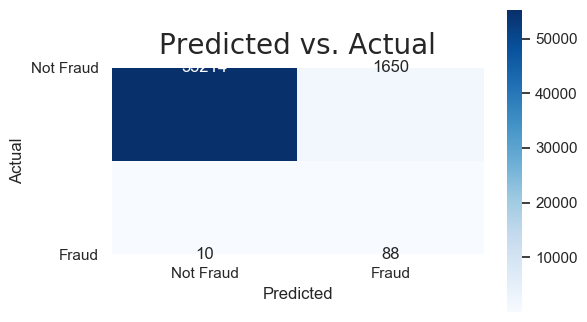

In [51]:
#fixed confusion matrix - random forest, validation
make_confusion_matrix_test(rf_grid, threshold=0.421)